In [278]:
%matplotlib inline
import sys
import pandas as pd
import networkx as nx
from itertools import combinations

In [279]:
# 기존 형식과 유사하게 Node class 정의
class Node:
    def __init__(self, linkedNode, latitude, longitude):
        self.linkedNode = linkedNode
        self.latitude = latitude
        self.longitude = longitude

In [280]:
# node_list 정의(바둑판식 6x6)
node_list = []
for i in range(0, 36):
    linkedNode = []
    if i+1 < 36 and (i+1)%6 != 0:
        linkedNode.append(i+1)
    if i-1 > -1 and (i-1)%6 != 5:
        linkedNode.append(i-1)
    if i+6 < 36:
        linkedNode.append(i+6)
    if i-6 > -1:
        linkedNode.append(i-6)
    node_list.append(Node(linkedNode, i%6, i//6))

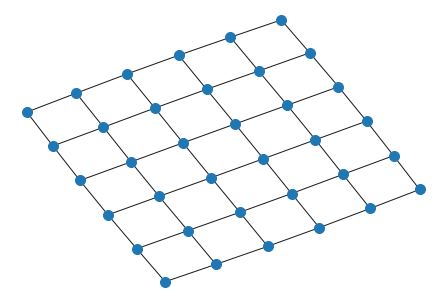

In [281]:
# 전체 그래프
G = nx.Graph()

# 0~35까지 노드 추가
for i in range(0, len(node_list)):
    G.add_node(i)

# 바둑판 식으로 edge 추가
for i in range(0, len(node_list)):
    for j in node_list[i].linkedNode:
        G.add_edge(i, j)

nx.draw(G, nx.kamada_kawai_layout(G), with_labels=False, node_size=100)

In [282]:
# a* algorithm에 필요한 node class
class AStarNode:
    def __init__(self, parent=None, nodeID=None, latitude=None, longitude=None):
        self.parent = parent
        self.nodeID = nodeID
        self.latitude = latitude
        self.longitude = longitude

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.latitude == other.latitude and self.longitude == other.longitude

In [283]:
def AStarAlgorithm(startID, endID):
    # startNode와 endNode 초기화
    startNode = AStarNode(None, startID, node_list[startID].latitude, node_list[startID].longitude)
    endNode = AStarNode(None, endID, node_list[endID].latitude, node_list[endID].longitude)

    # openList, closedList 초기화
    openList = []
    closedList = []

    # openList에 시작 노드 추가
    openList.append(startNode)

    # endNode를 찾을 때까지 실행
    while openList:
        # 현재 노드 지정
        currentNode = openList[0]
        currentIdx = 0

        # 이미 같은 노드가 openList에 있고, f 값이 더 크면
        # currentNode를 openList안에 있는 값으로 교체
        for index, item in enumerate(openList):
            if item.f < currentNode.f:
                currentNode = item
                currentIdx = index

        # openList에서 제거하고 closedList에 추가
        openList.pop(currentIdx)
        closedList.append(currentNode)

        # 현재 노드가 목적지면 current.position 추가하고
        # current의 부모로 이동
        if currentNode == endNode:
            path = []
            current = currentNode
            while current is not None:
                path.append([current.latitude, current.longitude])
                current = current.parent
            path = path[0:len(path)-1]
            return path[::-1]  # reverse
        
        children = []
        for nextNode in node_list[currentNode.nodeID].linkedNode:
            children.append(AStarNode(currentNode, nextNode, node_list[nextNode].latitude, node_list[nextNode].longitude))
        
        # children 모두 loop
        for child in children:

            # child가 closedList에 있으면 continue
            if child in closedList:
                continue

            # f, g, h 값 업데이트
            child.g = currentNode.g + 1
            child.h = ((child.latitude - endNode.latitude) ** 2) + ((child.longitude - endNode.longitude) ** 2)
            child.f = child.g + child.h

            # 자식이 openList에 있으고, g값이 더 크면 continue
            if len([openNode for openNode in openList
                    if child == openNode and child.g > openNode.g]) > 0:
                continue
                    
            openList.append(child)


In [284]:
def permutations_2(array, r):
    for i in range(len(array)):
        if r == 1:
            yield [array[i]]
        else:
            for next in permutations_2(array[:i]+array[i+1:], r-1):
                yield [array[i]] + next

In [285]:
def permutations_3(array, c, turn = 0, number_of_dest=[], cop_goal_array=[]):
    if turn > c - 1:
        yield cop_goal_array
        return
        
    if turn == 0:
        number_of_dest = [0 for i in range(len(array))]
        cop_goal_array = [0 for i in range(c)]

    for dest in range(0, len(array)):

        copy_number_of_dest = number_of_dest.copy()
        copy_cop_goal_array = cop_goal_array.copy()

        if copy_number_of_dest[dest] < c // len(array) + 1:
            copy_cop_goal_array[turn] = dest
            copy_number_of_dest[dest] += 1
            for next in permutations_3(array, c, turn+1, copy_number_of_dest, copy_cop_goal_array):
                yield next

In [286]:
def cal_next_cop_node(path=None, cur_rob_node=None):
    if len(path) == 0:
        return cur_rob_node
    else:
        return path[0][0] + path[0][1] * 6

In [287]:
def MoveNode(cur_cop_nodes, cur_rob_node):
    cops_path = []

    for i, cop_node in enumerate(cur_cop_nodes):
        cops_path.append([])
        for linkedNode in node_list[cur_rob_node].linkedNode:
            cops_path[i].append(AStarAlgorithm(cop_node, linkedNode))

    next_cop_nodes = [0 for i in range(len(cur_cop_nodes))]
    min_weight = 10000000
    
    if len(node_list[cur_rob_node].linkedNode) >= len(cur_cop_nodes):
        for index in permutations_2(list(range(0, len(node_list[cur_rob_node].linkedNode))), len(cur_cop_nodes)):
            weight = 0
            for i in range(0, len(cur_cop_nodes)):
                weight += len(cops_path[i][index[i]])
            if weight < min_weight:
                min_weight = weight
            for i in range(0, len(cur_cop_nodes)):
                next_cop_nodes[i] = cal_next_cop_node(cops_path[i][index[i]], cur_rob_node)
    else:
        for index in permutations_3(list(range(0, len(node_list[cur_rob_node].linkedNode))), len(cur_cop_nodes)):
            weight = 0
            for i in range(0, len(cur_cop_nodes)):
                weight += len(cops_path[i][index[i]])
            if weight < min_weight:
                min_weight = weight
            for i in range(0, len(cur_cop_nodes)):
                next_cop_nodes[i] = cal_next_cop_node(cops_path[i][index[i]], cur_rob_node)

    return next_cop_nodes

In [288]:
# example 1
cur_cop_nodes = [35, 32, 12]
cur_rob_node = 10

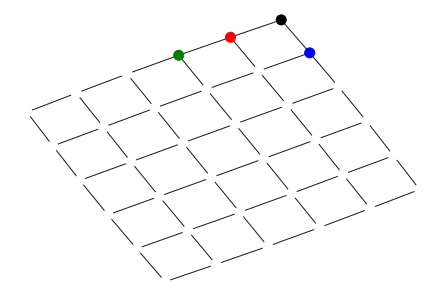

In [296]:
color_map = []
for cur_node in G:
    if cur_node == cur_cop_nodes[0]:
        color_map.append('red')
    elif cur_node == cur_cop_nodes[1]:
        color_map.append('green')
    elif cur_node == cur_cop_nodes[2]:
        color_map.append('blue')
    elif cur_node == cur_rob_node:
        color_map.append('black')
    else:
        color_map.append('white')

nx.draw(G, nx.kamada_kawai_layout(G), node_color=color_map, with_labels=False, node_size=100)

cur_cop_nodes = MoveNode(cur_cop_nodes, cur_rob_node)

In [290]:
# ↘
#cur_rob_node -= 1

# ↖
cur_rob_node += 1

# ↗
cur_rob_node -= 6

# ↙
#cur_rob_node += 6